# Contornos no OpenCV

## Componentes conexos e contornos

E se tivéssemos mais de um objeto vermelho na imagem? Como faríamos para identificá-los?

Fonte das imagens: [http://time.com/4299724/coca-cola-diet-coke-redesign/](http://time.com/4299724/coca-cola-diet-coke-redesign/)

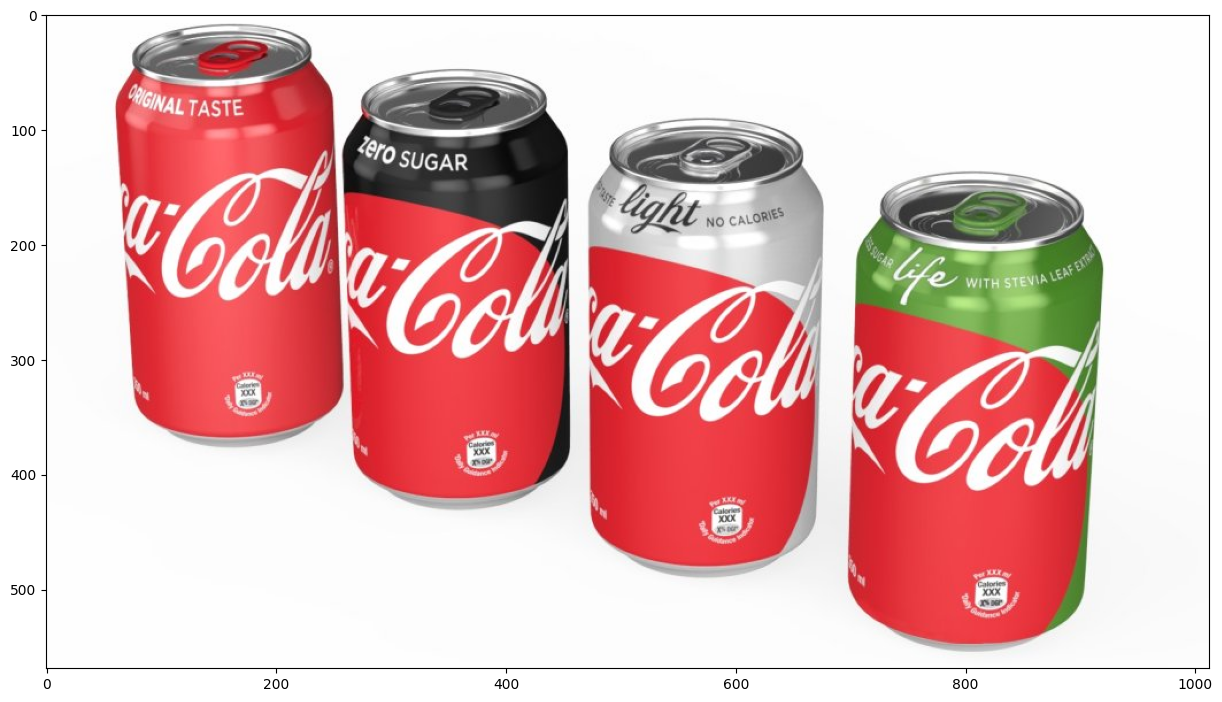

In [10]:
coke = cv2.imread("img/coke-cans.jpg")
coke_rgb= cv2.cvtColor(coke, cv2.COLOR_BGR2RGB)
coke_hsv= cv2.cvtColor(coke, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(15,10))
plt.imshow(coke_rgb)
plt.show()

Para detectar vermelho em HSV, não se esquecer de selecionar a faixa inferior e a superior do canal H

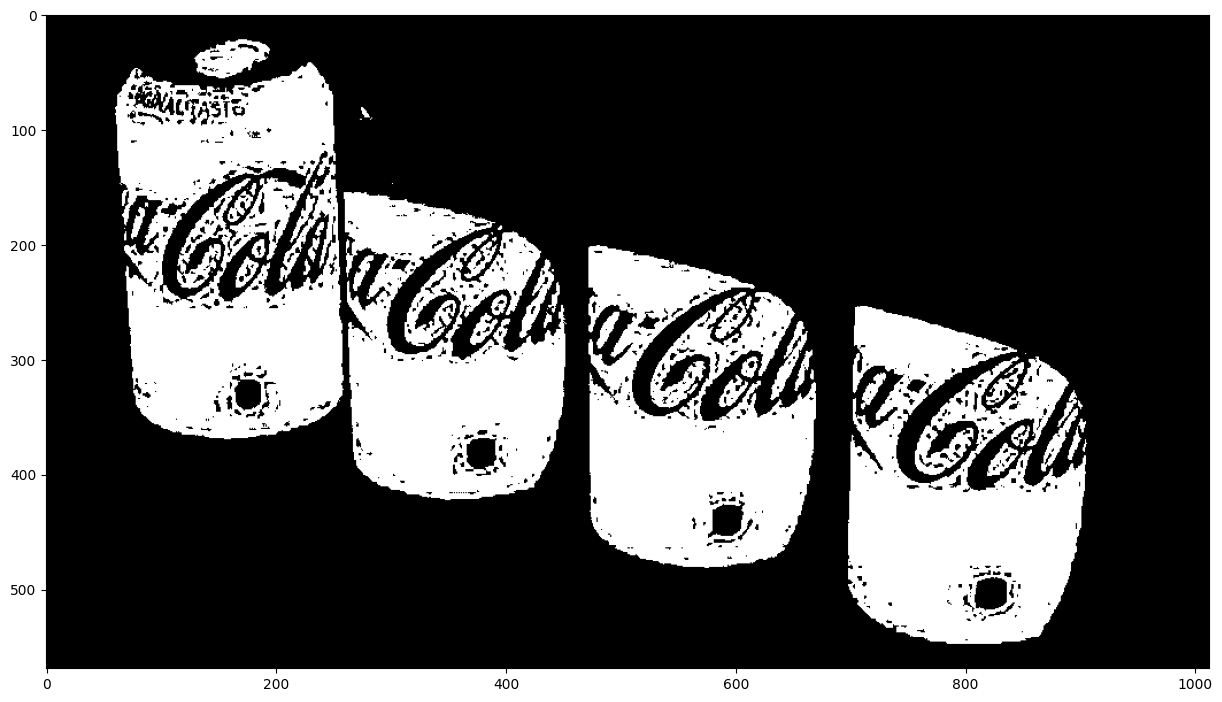

In [11]:
cor_menor1 = np.array([172, 50, 50])
cor_maior1 = np.array([180, 255, 255])
mask_coke1 = cv2.inRange(coke_hsv, cor_menor1, cor_maior1)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke1, cmap='gray')
plt.show()


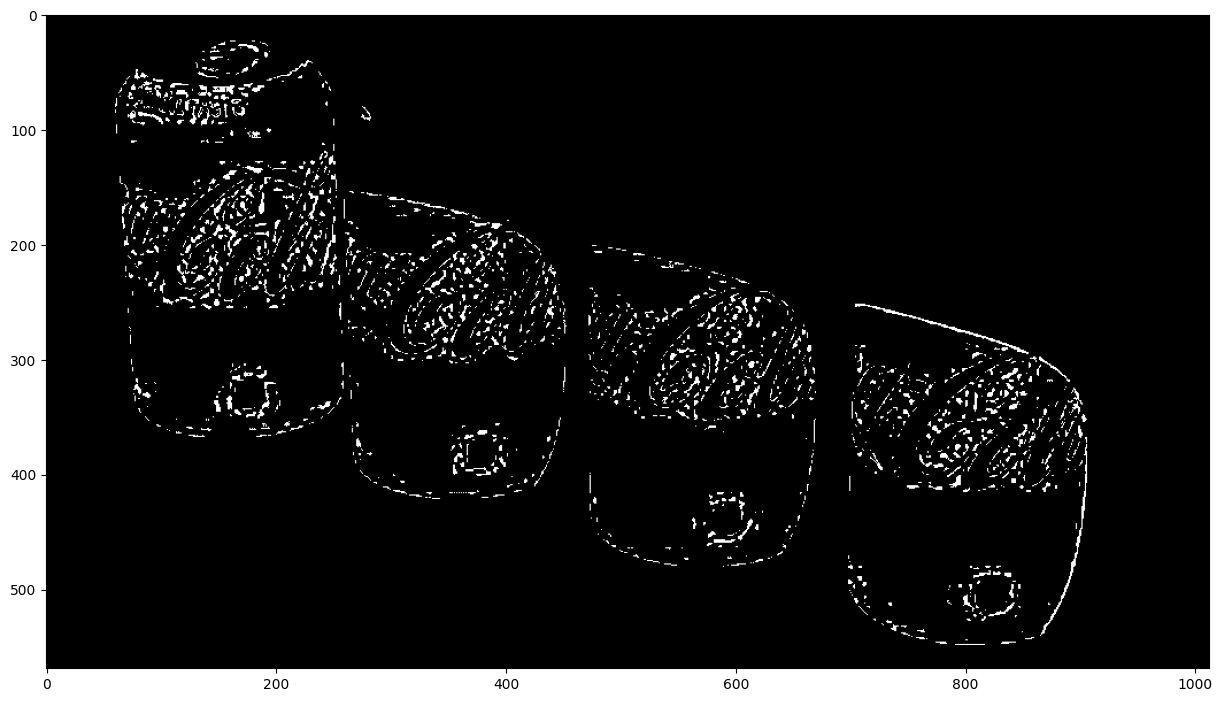

In [12]:
cor_menor2 = np.array([0, 50, 50])
cor_maior2 = np.array([8, 255, 255])
mask_coke2 = cv2.inRange(coke_hsv, cor_menor2, cor_maior2)

plt.figure(figsize=(15,10))
plt.imshow(mask_coke2, cmap='gray')
plt.show()

In [13]:
# Juntando as máscaras
mask_coke = cv2.bitwise_or(mask_coke1, mask_coke2)

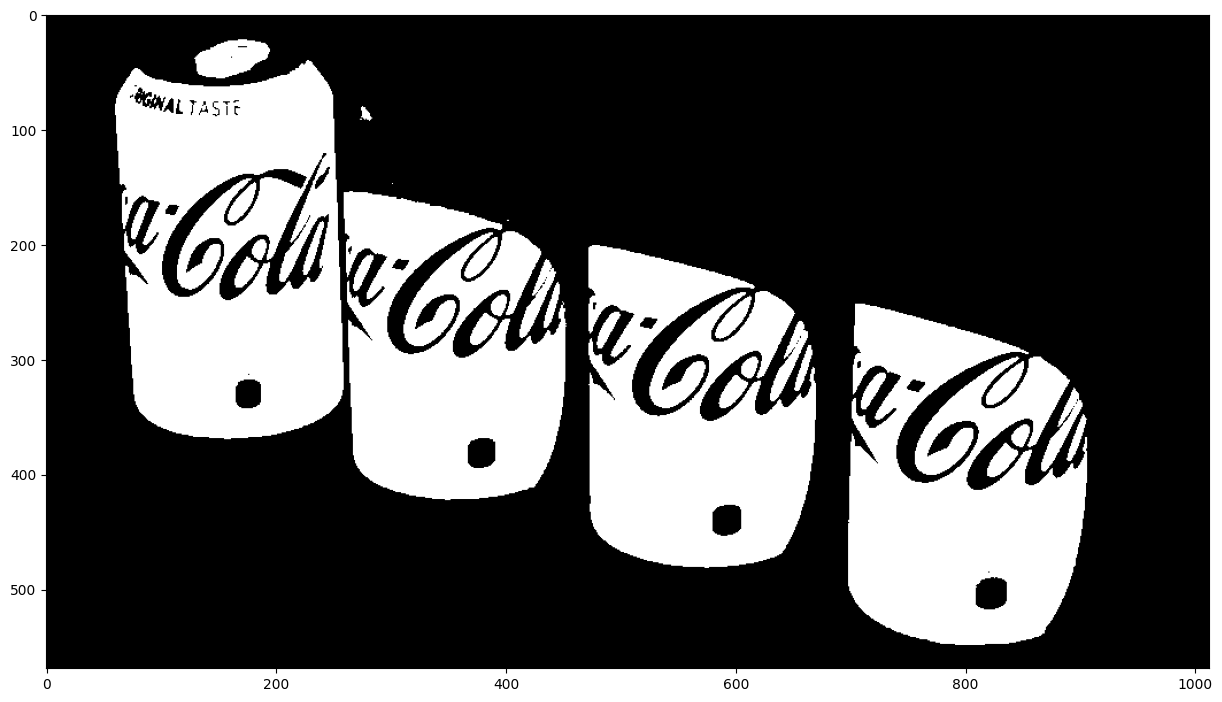

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(mask_coke, cmap="gray", vmin=0, vmax=255)
plt.show()

## Componentes conexos

Após a segmentação da imagem por mascaramento, podemos observar que os pixels de interesse podem formar um ou mais grupos conectados entre si, ou seja, conjuntos de pixels que se comunicam através de algum caminho que passa apenas por pixels de interesse (brancos)

![](img/retangulos.bmp) -> ![](img/retangulos_mask.bmp) -> ![](img/retangulos_ccomp.bmp)

No OpenCV, é possível encontrar componente conexos em imagens tons de cinza através da função `cv2.findContours()`. Ela considera pixels de valor maior do que 0 como pixels de interesse. 

Usamos a função da forma:

```
contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
```
onde:
- `mask` é a imagem com a máscara binária
- `cv2.RETR_CCOMP` indica que queremos organizar os contornos em componentes conexos e buracos dentro deles
- `cv2.CHAIN_APPROX_NONE` indica que queremos armazenar todos os pontos do contorno
- `contours` é uma lista de contornos, contendo os pontos a ele pertencententes
- `hierarchy` é uma lista indicando a organização dos contornos em termos dos componentes e de seus buracos


Os componentes conexos são representados através de seus contornos internos, ou seja, dos pixels de cada componente conexo que são vizinhos a pixels de fundo. Para desenhar os contornos em uma imagem, usamos a função `cv2.drawContours()`, que usamos da forma:

```
cv2.drawContours(imagem, contours, indice, cor)
```
- `imagem` é a imagem colorida ou tons de cinza a receber o contorno
- `contours` é a lista de contornos obtida com `cv2.findContours()`
- `indice` é o índice do contorno dentro da lista a ser desenhado; se indice < 0 desenha todos os contornos
- `cor` é a cor do pixel a ser usada para desenhar o contorno   



In [15]:
contornos, arvore = cv2.findContours(mask_coke.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
len(contornos)

111

In [16]:
contornos_img = coke_rgb.copy()
cv2.drawContours(contornos_img, contornos, -1, [0, 0, 255], 3);

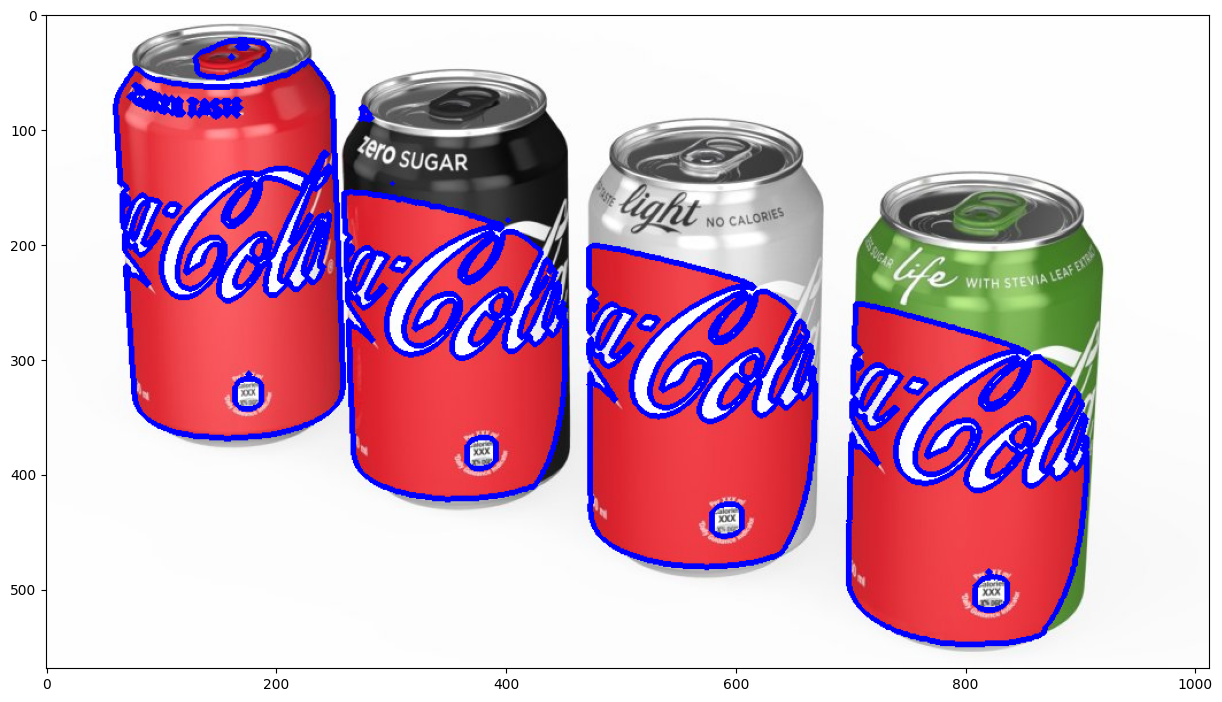

In [17]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

### Medidas dos contornos

A partir dos contornos, podemos tirar uma série de medidas como:
- **Área:** número de pixels petencentes ao contorno, calculada com `cv2.contourArea(contour)`
- **Centro de massa:** linha e coluna do centro de masssa do contorno

**Exemplo:** calcula o componente conexo de maior área e desenha seu contorno e o ponto do centro de massa 

#### Maior contorno

In [18]:
maior = None
maior_area = 0
for c in contornos:
    area = cv2.contourArea(c)
    if area > maior_area:
        maior_area = area
        maior = c

In [19]:
cv2.drawContours(contornos_img, [maior], -1, [0, 255, 255], 5);


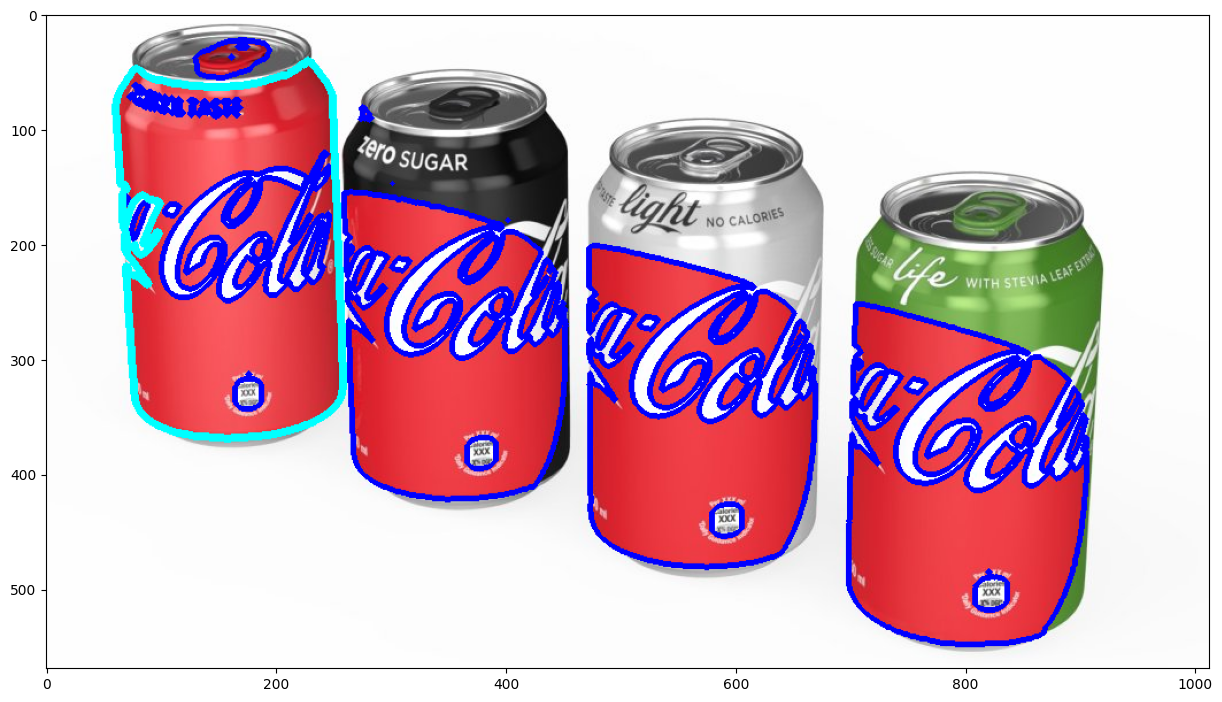

In [20]:
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

#### Centro de massa do contorno.

**Jeito 1** - mais preciso

In [21]:
def crosshair(img, point, size, color):
    """ Desenha um crosshair centrado no point.
        point deve ser uma tupla (x,y)
        color é uma tupla R,G,B uint8
    """
    x,y = point
    cv2.line(img,(x - size,y),(x + size,y),color,5)
    cv2.line(img,(x,y - size),(x, y + size),color,5)

In [22]:
""" Retorna uma tupla (cx, cy) que desenha o centro do contorno"""
M = cv2.moments(maior)
# Usando a expressão do centróide definida em: https://en.wikipedia.org/wiki/Image_moment
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

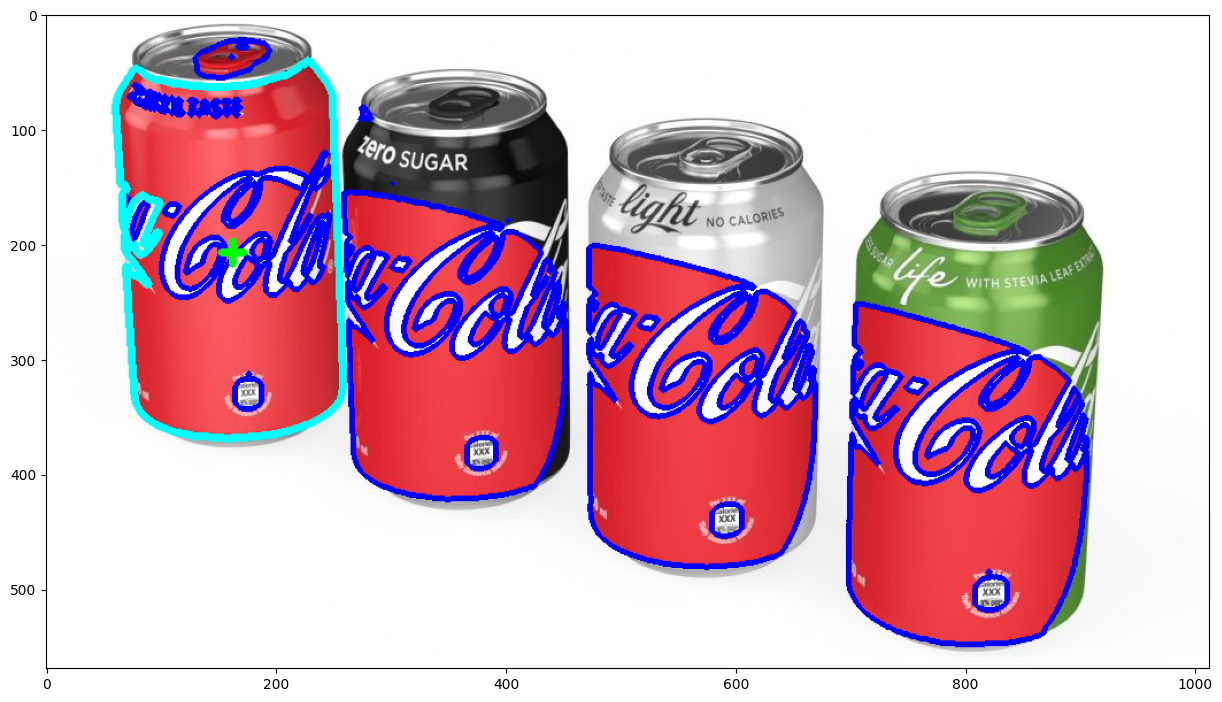

In [23]:
crosshair(contornos_img, (cX,cY), 10, (0,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

**Jeito 2** - aproximado

**ATENÇÃO:** essa técnica de calcular o centro de massa diretamente do contorno dá resultados melhores quando usado com contornos convexos e `cv2.CHAIN_APPROX_NONE`. Em outros casos, é melhor fazer como no jeito 1.

In [24]:
cX = int(maior[:,:,0].mean())
cY = int(maior[:,:,1].mean())

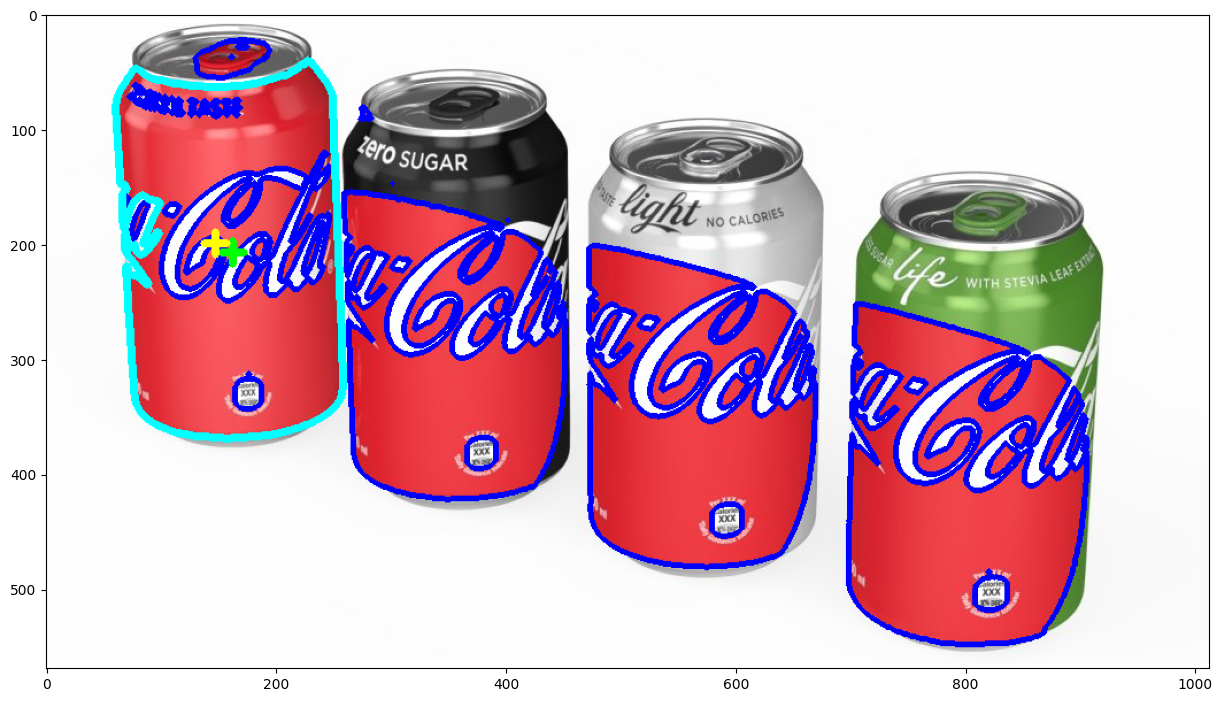

In [25]:
crosshair(contornos_img, (cX,cY), 10, (255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(contornos_img)
plt.show()

## Prática

**Exercício 1**: ainda trabalhando com as imagens das latinhas, use seus conhecimentos de segmentação de imagens para obter uma máscara que tenha somente o contorno externo das 4 latinhas.

**Exercício 2**: usando código, faça uma função que filtra a máscara anterior e deixa somente as latinhas da Coca-cola Life (a que tem a parte verde no topo). **Dica**: use as funções de contornos para analisar cada latinha individualmente. Depois disso, veja se a latinha contém uma quantidade de pixels verdes "grande".

<div id="hough"></div>